In [1]:
import cv2
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

# LoadData

使用官方提供的样本数据

In [ ]:
# 加载数据
# 由于是本地环境训练，无需调整csv中记录的images文件路径
center_images = []
measurements = []
left_correction = 0.2
right_correction = 0.2
with open("D:/17.Behavioral_Cloning_Project/data/data/driving_log.csv") as csv_file:
    reader = csv.reader(csv_file)
    for line in reader:
        for i in range(3):
            path = "D:/17.Behavioral_Cloning_Project/data/data/"+(line[i].replace(" ",""))
            image = imread(path)
            if i==0:
                measurement = float(line[3])
            elif i==1:
                measurement = float(line[3]) + left_correction
            elif i==2:
                measurement = float(line[3]) - right_correction
            # 添加正常数据
            center_images.append(image)
            measurements.append(measurement)
            # 添加翻转数据
            center_images.append(np.fliplr(image))
            measurements.append(-measurement)
            
x_train = np.array(center_images)
y_train = np.array(measurements)

In [3]:
# 数据结构
print("Number of images = %s"%str(x_train.shape[0]))
print("image.shape = %s"% str(x_train[0].shape))

Number of images = 48216
image.shape = (160, 320, 3)


# First Try

In [ ]:
# 初次尝试
# 使用最简单的模型

In [5]:
from keras.models import Sequential
from keras.layers import Flatten,Dense,Activation,Lambda
model = Sequential()
model.add(Flatten(input_shape=(160,320,3)))
model.add(Dense(1))
model.compile(loss="mse",optimizer='adam')
model.fit(x_train,y_train,epochs=6,batch_size=32,validation_split=0.2,shuffle=True)
model.save('model.h5')

Using TensorFlow backend.


Train on 38572 samples, validate on 9644 samples
Epoch 1/6
38572/38572 [==============================] - 33s 866us/step - loss: 801017.4526 - val_loss: 13256.0901
Epoch 2/6
38572/38572 [==============================] - 31s 812us/step - loss: 235864.9873 - val_loss: 1382818.6456
Epoch 3/6
38572/38572 [==============================] - 32s 820us/step - loss: 321948.6909 - val_loss: 33728.4432
Epoch 4/6
38572/38572 [==============================] - 32s 819us/step - loss: 336687.4063 - val_loss: 34645.2206
Epoch 5/6
38572/38572 [==============================] - 33s 861us/step - loss: 324658.7353 - val_loss: 25951.2434
Epoch 6/6
38572/38572 [==============================] - 33s 843us/step - loss: 313515.9072 - val_loss: 12053.1580


#### 在模拟器中验证 model效果
在cmd中运行以下命令： 
python drive.py model.h5  

效果有点差呦  
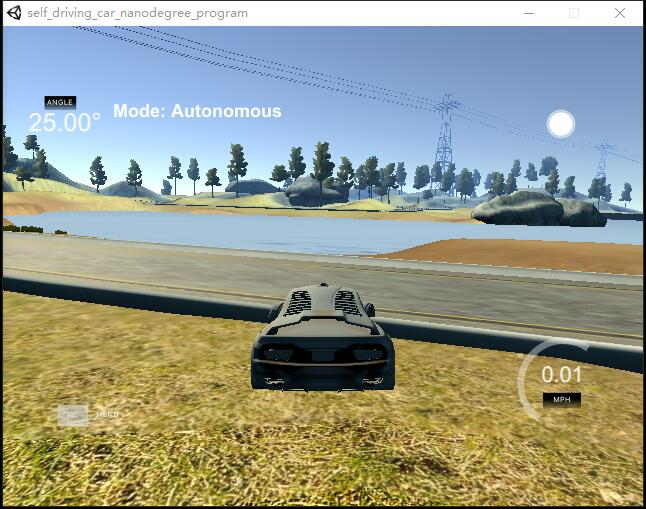

# Preprocess 

In [6]:
model = Sequential()
# 添加归一化处理
model.add(Lambda(lambda x: x/255.0 - 0.5,input_shape=(160,320,3)))
model.add(Flatten())
model.add(Dense(1))
model.compile(loss="mse",optimizer='adam')
model.fit(x_train,y_train,epochs=6,batch_size=32,validation_split=0.2,shuffle=True)
model.save('model.h5')

Train on 38572 samples, validate on 9644 samples
Epoch 1/6
38572/38572 [==============================] - 34s 874us/step - loss: 3.2101 - val_loss: 3.9316
Epoch 2/6
38572/38572 [==============================] - 34s 870us/step - loss: 3.9915 - val_loss: 2.9916
Epoch 3/6
38572/38572 [==============================] - 34s 876us/step - loss: 4.1680 - val_loss: 3.7083
Epoch 4/6
38572/38572 [==============================] - 32s 835us/step - loss: 3.9986 - val_loss: 3.0154
Epoch 5/6
38572/38572 [==============================] - 32s 841us/step - loss: 4.1148 - val_loss: 3.2288
Epoch 6/6
38572/38572 [==============================] - 32s 835us/step - loss: 3.5895 - val_loss: 3.0222


效果比之前好一些，但是还是不能完成整个赛道
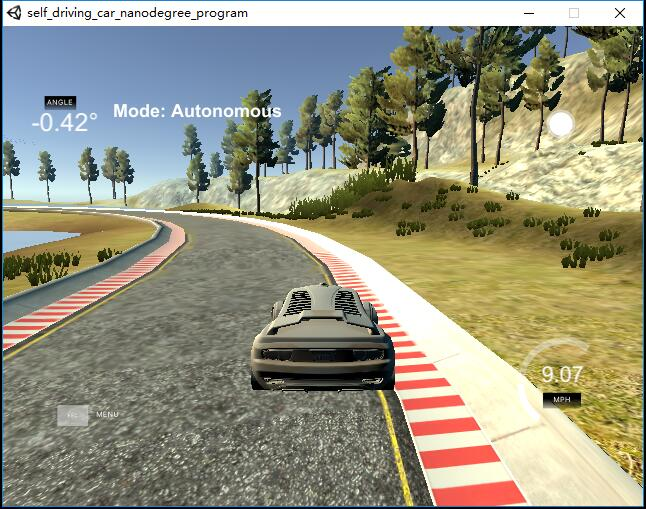

# Use LeNet model

In [7]:
from keras.models import Sequential
from keras.layers import Dense,Lambda,Cropping2D,Conv2D,Dense,Activation,MaxPooling2D,Flatten

model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5,input_shape=(160,320,3)))
model.add(Conv2D(6,(5,5),activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(6,(5,5),activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(84))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

model.fit(x_train,y_train,epochs=5,batch_size=32,validation_split=0.2,shuffle=True)
model.save('model.h5')

Train on 38572 samples, validate on 9644 samples
Epoch 1/5
38572/38572 [==============================] - 47s 1ms/step - loss: 0.4505 - val_loss: 0.0127
Epoch 2/5
38572/38572 [==============================] - 47s 1ms/step - loss: 0.0102 - val_loss: 0.0121
Epoch 3/5
38572/38572 [==============================] - 46s 1ms/step - loss: 0.0089 - val_loss: 0.0124
Epoch 4/5
38572/38572 [==============================] - 46s 1ms/step - loss: 0.0082 - val_loss: 0.0126
Epoch 5/5
38572/38572 [==============================] - 47s 1ms/step - loss: 0.0077 - val_loss: 0.0123


效果不错  
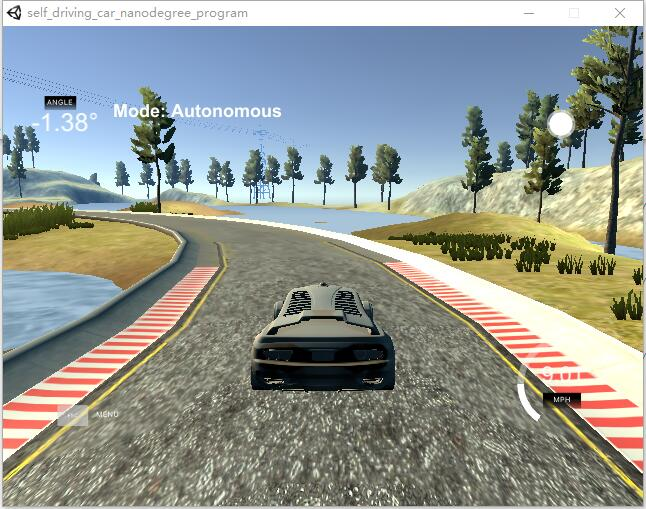

但是还是会失败  
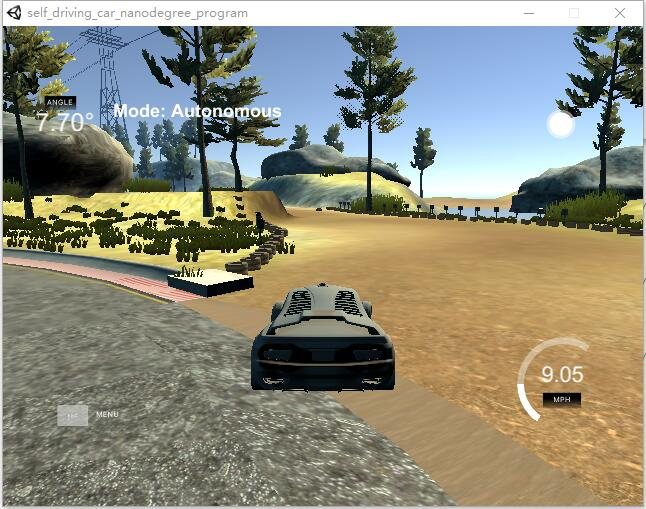

# Data Augmentation

使用自己收集的数据：  
- 正向2圈
- 反向2圈
- 弯道数据

In [2]:
# 加载数据
# 由于是本地环境训练，无需调整csv中记录的images文件路径
center_images = []
measurements = []

left_correction = 0.2
right_correction = 0.2

# 加载第一圈数据
with open("D:/17.Behavioral_Cloning_Project/forward_data/driving_log.csv") as csv_file:
    reader = csv.reader(csv_file)
    for line in reader:
        for i in range(3):
            image = imread(line[i])
            if i==0:
                measurement = float(line[3])
            elif i==1:
                measurement = float(line[3]) + left_correction
            elif i==2:
                measurement = float(line[3]) - right_correction
            # 添加正常数据
            center_images.append(image)
            measurements.append(measurement)
            # 添加翻转数据
            center_images.append(np.fliplr(image))
            measurements.append(-measurement)
# 加载第二圈数据        
with open("D:/17.Behavioral_Cloning_Project/forward_data_02/driving_log.csv") as csv_file:
    reader = csv.reader(csv_file)
    for line in reader:
        for i in range(3):
            image = imread(line[i])
            if i==0:
                measurement = float(line[3])
            elif i==1:
                measurement = float(line[3]) + left_correction
            elif i==2:
                measurement = float(line[3]) - right_correction
            # 添加正常数据
            center_images.append(image)
            measurements.append(measurement)
            # 添加翻转数据
            center_images.append(np.fliplr(image))
            measurements.append(-measurement)
        
# 加载反向第一圈数据
with open("D:/17.Behavioral_Cloning_Project/reverse_data/driving_log.csv") as csv_file:
    reader = csv.reader(csv_file)
    for line in reader:
        for i in range(3):
            image = imread(line[i])
            if i==0:
                measurement = float(line[3])
            elif i==1:
                measurement = float(line[3]) + left_correction
            elif i==2:
                measurement = float(line[3]) - right_correction
            # 添加正常数据
            center_images.append(image)
            measurements.append(measurement)
            # 添加翻转数据
            center_images.append(np.fliplr(image))
            measurements.append(-measurement)

# 加载反向第二圈数据
with open("D:/17.Behavioral_Cloning_Project/reverse_data_02/driving_log.csv") as csv_file:
    reader = csv.reader(csv_file)
    for line in reader:
        for i in range(3):
            image = imread(line[i])
            if i==0:
                measurement = float(line[3])
            elif i==1:
                measurement = float(line[3]) + left_correction
            elif i==2:
                measurement = float(line[3]) - right_correction
            # 添加正常数据
            center_images.append(image)
            measurements.append(measurement)
            # 添加翻转数据
            center_images.append(np.fliplr(image))
            measurements.append(-measurement)

            
# 加载弯道数据
with open("D:/17.Behavioral_Cloning_Project/curve_data/driving_log.csv") as csv_file:
    reader = csv.reader(csv_file)
    for line in reader:
        for i in range(3):
            image = imread(line[i])
            if i==0:
                measurement = float(line[3])
            elif i==1:
                measurement = float(line[3]) + left_correction
            elif i==2:
                measurement = float(line[3]) - right_correction
            # 添加正常数据
            center_images.append(image)
            measurements.append(measurement)
            # 添加翻转数据
            center_images.append(np.fliplr(image))
            measurements.append(-measurement)
         
        
x_train = np.array(center_images)
y_train = np.array(measurements)

# Data shape

In [3]:
# 数据结构
print("Number of images = %s"%str(x_train.shape[0]))
print("image.shape = %s"% str(x_train[0].shape))

Number of images = 97284
image.shape = (160, 320, 3)


# Using Multiple Cameras

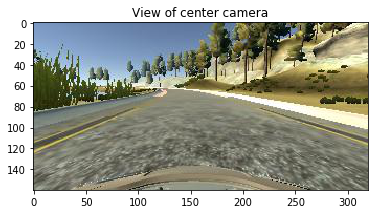

In [4]:
# 数据展示
plt.imshow(x_train[0])
plt.title("View of center camera")
plt.savefig("./images/center_camera.jpg")
plt.show()

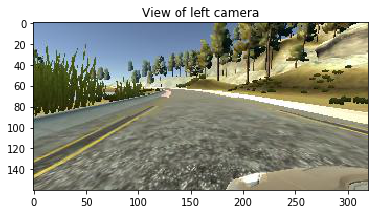

In [5]:
plt.imshow(x_train[2])
plt.title("View of left camera")
plt.savefig("./images/left_camera.jpg")
plt.show()

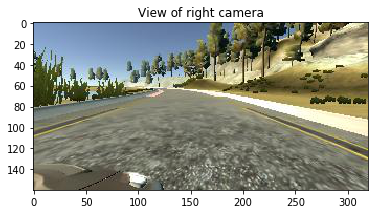

In [6]:
plt.imshow(x_train[4])
plt.title("View of right camera")
plt.savefig("./images/right_camera.jpg")
plt.show()

# Using fliped Images

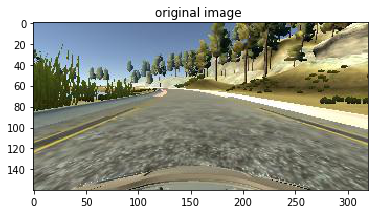

In [7]:
# 数据展示
plt.imshow(x_train[0])
plt.title("original image ")
plt.savefig("./images/original_image.jpg")
plt.show()

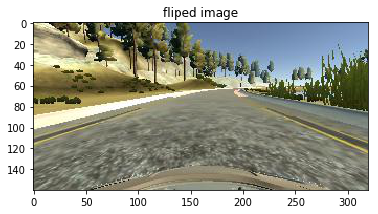

In [8]:
# 数据展示
plt.imshow(x_train[1])
plt.title("fliped image")
plt.savefig("./images/fliped_image.jpg")
plt.show()

# Cropping Images

In [ ]:
model = Sequential()
model.add(Cropping2D(cropping=((50,25), (0,0)), input_shape=(3,160,320)))

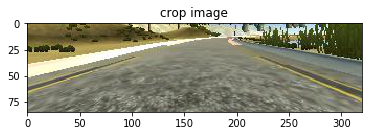

In [13]:
# 数据展示
plt.imshow(x_train[1][50:135,0:320])
plt.title("crop image")
plt.savefig("./images/crop_image.jpg")
plt.show()

# Use NVIDIA's model architecture

In [14]:
from keras.models import Sequential
from keras.layers import Dense,Lambda,Cropping2D,Conv2D,Dense,Activation,MaxPooling2D,Flatten

model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5,input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((50,25), (0,0))))
model.add(Conv2D(24,(5,5),strides=(2,2) ,activation='relu'))
model.add(Conv2D(36,(5,5),strides=(2,2) ,activation='relu'))
model.add(Conv2D(48,(5,5),strides=(2,2) ,activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
model.fit(x_train,y_train,epochs=5,validation_split=0.2,shuffle=True)
model.save('model.h5')

Using TensorFlow backend.


Train on 77827 samples, validate on 19457 samples
Epoch 1/5
77827/77827 [==============================] - 85s 1ms/step - loss: 0.0342 - val_loss: 0.0417
Epoch 2/5
77827/77827 [==============================] - 82s 1ms/step - loss: 0.0308 - val_loss: 0.0412
Epoch 3/5
77827/77827 [==============================] - 82s 1ms/step - loss: 0.0297 - val_loss: 0.0444
Epoch 4/5
77827/77827 [==============================] - 82s 1ms/step - loss: 0.0285 - val_loss: 0.0454
Epoch 5/5
77827/77827 [==============================] - 85s 1ms/step - loss: 0.0272 - val_loss: 0.0421


# summary
结果表明：使用多种类型数据，多个摄像头数据，将图像进行翻转，裁剪后，传入NVIDIA的模型中，能够建立出效果良好的模型；  
下面将分别使用官方数据和自己收集的数据进行模型训练及测试。

# 导出图片

使用官方提供的数据：   
python drive.py model.h5 run1  


使用自己收集的数据：  
python drive.py model.h5 run2

# 压缩视频
使用官方提供的数据：   
python video.py run1   


使用自己收集的数据：   
python video.py run2

# 视频展示

In [1]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#### 使用官方数据的测试视频

In [5]:
HTML("""
<video width="480" height="270" controls>
  <source src="{0}">
</video>
""".format("./run1.mp4"))

#### 使用自己收集的数据的测试视频

In [6]:
HTML("""
<video width="480" height="270" controls>
  <source src="{0}">
</video>
""".format("./run2.mp4"))